# Main Task

## Libraries

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

## Instantiating SparkSession & Load the Dataset

In [3]:
spark = (SparkSession.builder
         .master("local[*]")
         .appName("Spotify Data Analysis")
         .config("spark.ui.showConsoleProgress", "false")
         .getOrCreate())
spark.sparkContext.setLogLevel("ERROR")

24/04/18 17:26:38 WARN Utils: Your hostname, Yoda-plus resolves to a loopback address: 127.0.1.1; using 192.168.1.101 instead (on interface wlp0s20f3)
24/04/18 17:26:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/18 17:26:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.parquet("data/spotify.parquet")

## Check the Schema

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)




1. **`id`**: The unique identifier for each track on Spotify. This is typically a string of characters that Spotify uses to uniquely identify a song in their system.

2. **`name`**: The name of the track. This is a string that represents the title of the song.

3. **`album`**: The name of the album on which the track appears. This helps in identifying collections of songs released together by an artist.

4. **`album_id`**: Similar to the track ID, this is a unique identifier for the album. Useful for linking tracks to specific albums.

5. **`artists`**: The name of the artist or artists who performed or created the track. This field might contain multiple names if the track has multiple artists.

6. **`artist_ids`**: A unique identifier or identifiers for the artist or artists. Like `artists`, this can include multiple IDs separated by a delimiter if there are multiple artists.

7. **`track_number`**: The track's position on its album. This is a numerical order of where the track appears on its respective album.

8. **`disc_number`**: The number of the disc on which the track appears if the album has multiple discs.

9. **`explicit`**: A boolean value indicating whether the track has explicit content. True means there is explicit content; false means there isn't.

10. **`danceability`**: A measure from 0.0 to 1.0 representing how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

11. **`energy`**: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

12. **`key`**: The key the track is in. Integers map to pitches using standard Pitch Class notation.

13. **`loudness`**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

14. **`mode`**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

15. **`speechiness`**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value.

16. **`acousticness`**: A measure from 0.0 to 1.0 of how acoustic a track is. A score of 1.0 means the track is most likely an acoustic one.

17. **`instrumentalness`**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

18. **`liveness`**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

19. **`valence`**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric).

20. **`tempo`**: The overall estimated tempo of a track in beats per minute (BPM).

21. **`duration_ms`**: The duration of the track in milliseconds.

22. **`time_signature`**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

23. **`year`**: The year in which the track was released.

24. **`release_date`**: T of insights can be extracted from each attribute.he exact date on which the track was released.

In [6]:
df.show(1)

+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|Testify|The Battle Of Los...|2eia0myWFgoHuttJy...|['Rage Against Th...|['2d0hyoQ5

## Preprocess the Data

In [7]:
final_df = (df
            .select("name", 
                    "release_date", "year",
                    "album", 
                    "artists", 
                    "track_number", 
                    'disc_number', 
                    'explicit', 
                    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                    'duration_ms'
                    )
            .withColumn("release_date", F.to_date("release_date", 
                                                  "yyyy-MM-dd"))
            .dropna(subset=["release_date"])
            .withColumn("artists", F.split(F.regexp_replace("artists", r"[\[\]']", ""), ","))
            .withColumn("duration_s", F.col("duration_ms") / 1000)
            .withColumn("minute", (F.col("duration_s") / 60).cast("int"))
            .withColumn("second", (F.col("duration_s") % 60).cast("int"))
            .withColumn("duration", F.concat(F.format_string("%02d", "minute"), F.lit(":"), F.format_string("%02d", "second")))
            .withColumn("decade", F.concat((F.floor(F.col("year") / 10) * 10).cast("string"), F.lit("s")))
            .where(F.col('year') > 1900))

In [8]:
final_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- year: long (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- duration_s: double (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)
 |-- duration: string (nullable = false)
 |-- decade: string (nullable = true)


In [9]:
n_null_dates = final_df.where(F.col("release_date").isNull()).count()
n_null_dates

0

In [10]:
n_deleted = df.count() - final_df.count()
n_deleted

131200

In [11]:
del n_deleted, n_null_dates

In [12]:
final_df.show(5)

+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+----------+------+------+--------+------+
|                name|release_date|year|               album|             artists|track_number|disc_number|explicit|danceability|energy|          loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|duration_s|minute|second|duration|decade|
+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+----------+------+------+--------+------+
|             Testify|  1999-11-02|1999|The Battle Of Los...|[Rage Against The...|           1|          1|   false|        0.47| 0.978|            -5.399|     0.0727|     

## Data Aggregation, filtering and Transformation

#### Annual and Decennial Release Monitor

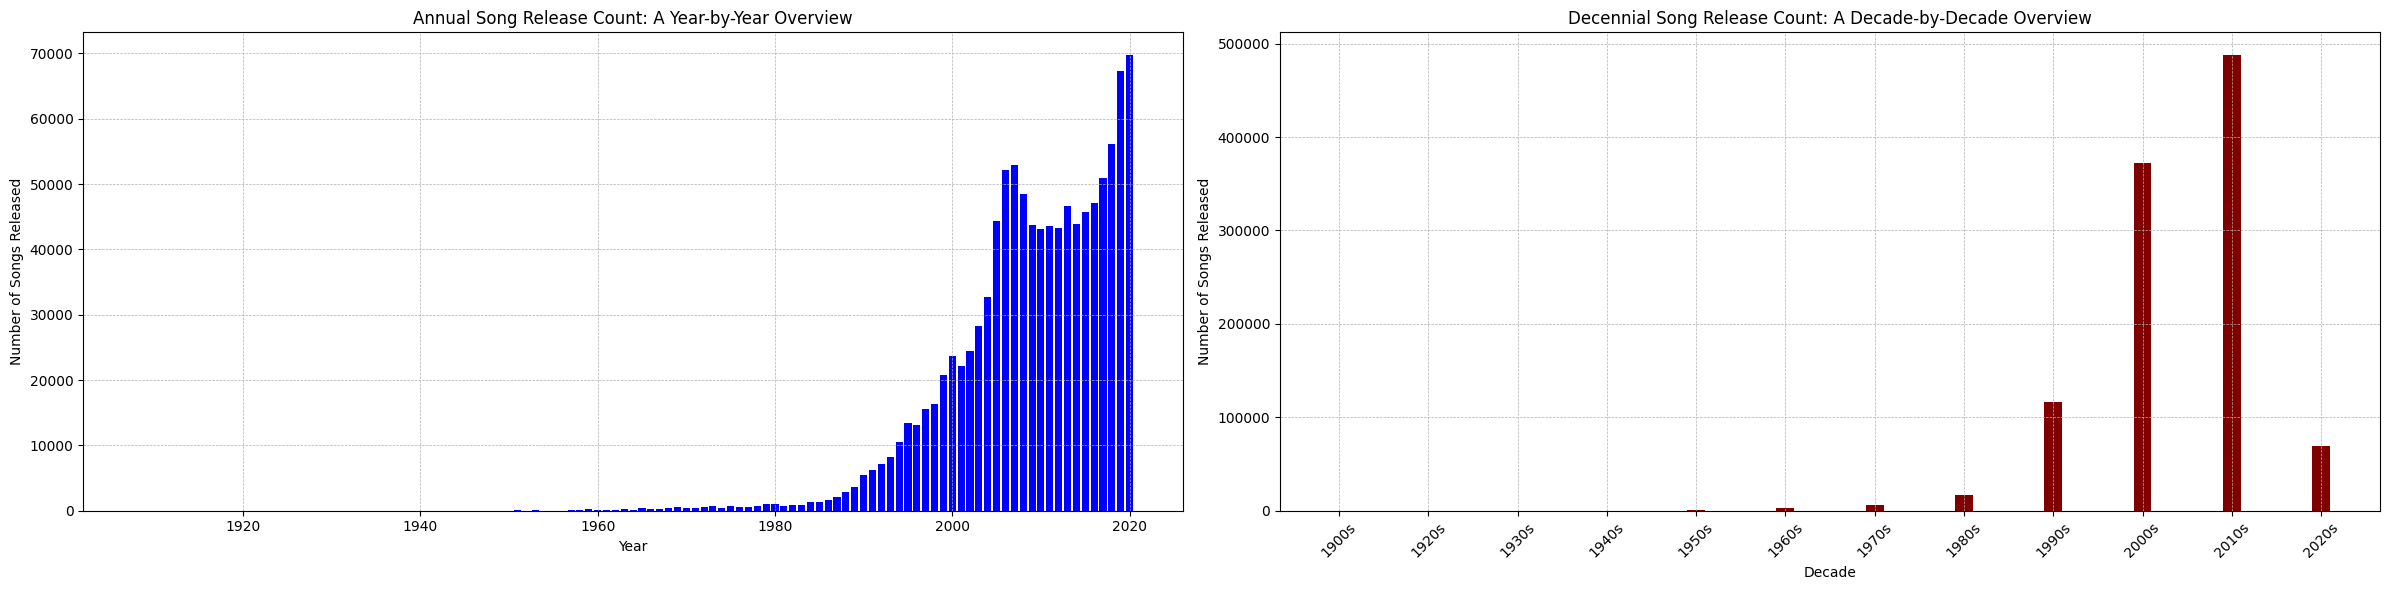

In [13]:
annual_data = (final_df
               .groupby("year")
               .agg(F.count("name").alias('number_of_songs'))
               .orderBy("year")).toPandas()
decennial_data = (final_df
               .groupby("decade")
               .agg(F.count("name").alias('number_of_songs'))
               .orderBy("decade")).toPandas()

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.bar(annual_data['year'], annual_data['number_of_songs'], color='blue')
plt.title("Annual Song Release Count: A Year-by-Year Overview")
plt.xlabel("Year")
plt.ylabel("Number of Songs Released")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.bar(decennial_data['decade'], decennial_data['number_of_songs'], color='maroon', width=0.2)
plt.title("Decennial Song Release Count: A Decade-by-Decade Overview")
plt.xlabel("Decade")
plt.ylabel("Number of Songs Released")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
del annual_data, decennial_data

#### Average Features by Decade (danceability, energy, tempo):

In [14]:
decennial_data = (final_df
                  .groupBy("decade")
                  .agg(F.avg("danceability").alias("avg_danceability"),
                       F.avg("energy").alias("avg_energy"),
                       F.avg("valence").alias("avg_valence"))
                  .orderBy("decade")).toPandas()
decennial_data

,decade,avg_danceability,avg_energy,avg_valence
0,1900s,0.604105,0.473695,0.657000
1,1920s,0.314312,0.129225,0.148969
2,1930s,0.567870,0.353774,0.652746
3,1940s,0.497235,0.347218,0.432524
4,1950s,0.469220,0.317531,0.485975
5,1960s,0.495494,0.432276,0.562321
6,1970s,0.496901,0.491623,0.542375
7,1980s,0.478369,0.446187,0.468070
8,1990s,0.455030,0.378853,0.411490
9,2000s,0.490304,0.495701,0.442038


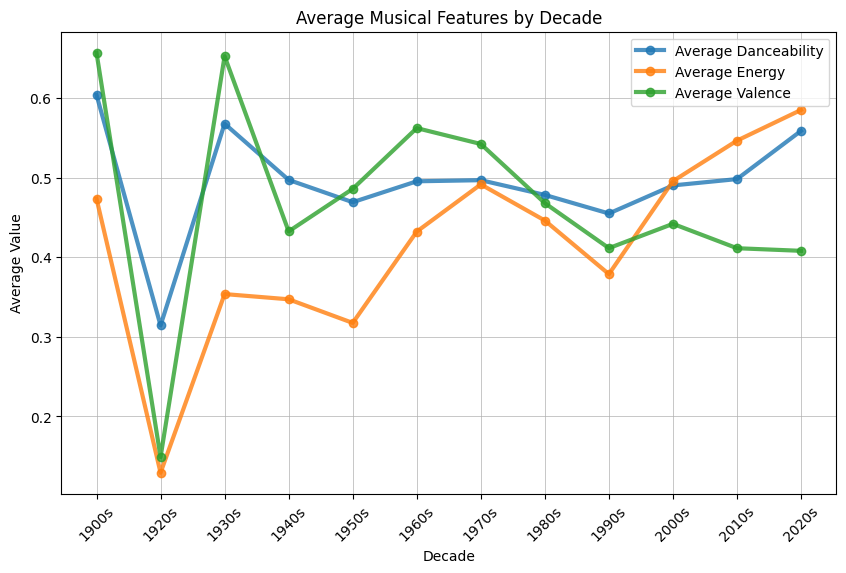

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(decennial_data['decade'], decennial_data['avg_danceability'], label='Average Danceability', marker='o', linewidth=3, alpha=0.8)
plt.plot(decennial_data['decade'], decennial_data['avg_energy'], label='Average Energy', marker='o', linewidth=3, alpha=0.8)
plt.plot(decennial_data['decade'], decennial_data['avg_valence'], label='Average Valence', marker='o', linewidth=3, alpha=0.8)
plt.title('Average Musical Features by Decade')
plt.xlabel('Decade')
plt.xticks(rotation=45)
plt.ylabel('Average Value')
plt.legend()
plt.grid(linewidth=0.5)
plt.show()
del decennial_data

#### Average Duration

In [16]:
(final_df
 .agg(F.avg("minute").cast("int").alias("min"), 
      F.avg("second").cast("int").alias("sec"))
 .select(F.concat(F.format_string("%02d", "min"), F.lit(":"), F.format_string("%02d", "sec")).alias("average_duration"))
 .show())

+----------------+
|average_duration|
+----------------+
|           03:29|
+----------------+


## Investigating Top-K Records

In [17]:
k = 10

### Top-k Tracks by Danceability

In [18]:
(final_df
 .select("name", "danceability")
 .orderBy(F.desc("danceability"))
 .limit(10)
 .show(truncate=False))

+------------------------------------+------------+
|name                                |danceability|
+------------------------------------+------------+
|Unendlich                           |1.0         |
|Na-try Mo Na Ba Ako                 |0.994       |
|Roll Like Dis / Cha-cha Slide Part 2|0.993       |
|Techno Is Not Fault                 |0.992       |
|Aussie, Aussie (O, Sige!)           |0.991       |
|Le casse-tête (Cannelle, Pruneau)   |0.991       |
|New Life                            |0.99        |
|Esther's Vice                       |0.99        |
|Go Nuts                             |0.988       |
|ääniesineitâ 2                      |0.987       |
+------------------------------------+------------+


#### Top-k Artists with the Highest Number of Tracks:

In [19]:
(final_df
 .select(F.explode("artists").alias("artist"))
 .groupby("artist")
 .count()
 .orderBy(F.desc("count"))
 .limit(k)
 .show(truncate=False))

+-----------------------+-----+
|artist                 |count|
+-----------------------+-----+
|Johann Sebastian Bach  |8429 |
|Ludwig van Beethoven   |5124 |
|Wolfgang Amadeus Mozart|3321 |
|George Frideric Handel |2709 |
|Antonio Vivaldi        |2615 |
| Neeme Järvi           |2256 |
|Franz Joseph Haydn     |2090 |
|Sergei Prokofiev       |1996 |
|Dmitri Shostakovich    |1829 |
|Frédéric Chopin        |1828 |
+-----------------------+-----+


### Top-k Artists with the Highest/Lowest Average Valence

In [20]:
(final_df
 .select('valence', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("valence").alias("avg_valence"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy(F.desc("avg_valence"))
 .limit(k)
 .show())

+--------------------+------------------+-------------------+
|              artist|       avg_valence|duration in seconds|
+--------------------+------------------+-------------------+
|        Gerry Wimsey|               1.0|              103.4|
|     mike mcgoldrick|             0.994|            192.053|
|       Niall Vallely|             0.994|            192.053|
|        Fred Whiting|             0.994|            143.933|
|       dezi donnelly|             0.994|            192.053|
|    Tsvyatko Blagoev|             0.993|             166.96|
|   Bridge Céilí Band|             0.993|              205.2|
|   The Hyde Brothers|             0.991|            177.493|
|      The Wear Famly|             0.989|             72.422|
| Tom Schaefer & P...|0.9886428571428569| 172.98671428571427|
+--------------------+------------------+-------------------+


In [21]:
(final_df
 .select('valence', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("valence").alias("avg_valence"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy("avg_valence")
 .limit(k)
 .show())

+--------------------+-----------+-------------------+
|              artist|avg_valence|duration in seconds|
+--------------------+-----------+-------------------+
|    Steve Buckingham|        0.0|              16.52|
|         Pinche Pogo|        0.0|            255.027|
|      Caitlin Stasey|        0.0|  7.022499999999999|
|Estacion Identifi...|        0.0|             12.013|
|    Reanin Johannink|        0.0|              7.968|
|         Eli Jah One|        0.0|              5.253|
|          Eli Vargas|        0.0|             5.8425|
|Nils Lofgren w/ J...|        0.0|             11.067|
|        Harry Wilson|        0.0|             15.867|
|      Kiminori Chiba|        0.0|             14.141|
+--------------------+-----------+-------------------+


### Top-k Artists with the Highest/Lowest Average Danceability

In [22]:
(final_df
 .select('danceability', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("danceability").alias("avg_danceability"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy(F.desc("avg_danceability"))
 .limit(k)
 .show())

+----------------+----------------+-------------------+
|          artist|avg_danceability|duration in seconds|
+----------------+----------------+-------------------+
|Andrea HEinstein|           0.992|            337.058|
|         Juelz B|           0.987|            198.347|
|             Gen|           0.987|            170.713|
|     LILDRUGHILL|           0.984|              187.5|
|            Liêm|           0.983|            426.945|
|        3rd Face|           0.981|            412.138|
|      Money Maru|           0.981|            250.333|
|     Lul Florida|            0.98|            247.798|
|    Franko Murry|            0.98|            219.816|
|        347aidan|            0.98|            180.139|
+----------------+----------------+-------------------+


In [23]:
(final_df
 .select('danceability', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("danceability").alias("avg_danceability"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy("avg_danceability")
 .limit(k)
 .show())

+--------------------+----------------+-------------------+
|              artist|avg_danceability|duration in seconds|
+--------------------+----------------+-------------------+
|       Chris Berardo|             0.0|             14.982|
|         Pinche Pogo|             0.0|            255.027|
|        Ben Gwilliam|             0.0|             172.04|
|        Leigh Parker|             0.0|              7.152|
|        Johann Mertz|             0.0|             253.48|
|         Brian Frejo|             0.0|            10.3735|
|      Hunter Silides|             0.0|             12.133|
|      Kiminori Chiba|             0.0|             14.141|
| Peace Camp Houst...|             0.0|             14.186|
|Estacion Identifi...|             0.0|             12.013|
+--------------------+----------------+-------------------+


### Top-K Energetic Tracks

In [24]:
(final_df
.select('name', 'energy', 'duration')
.orderBy(F.desc("energy"))
.limit(k)
.show(truncate=False))

+----------------------------+------+--------+
|name                        |energy|duration|
+----------------------------+------+--------+
|Skald Au Satans Sol         |1.0   |04:28   |
|Rapai - Drumming Competition|1.0   |00:37   |
|Slottet I Det Fjerne        |1.0   |04:45   |
|Did You Cum?                |1.0   |01:17   |
|Graven Takeheimens Saler    |1.0   |04:59   |
|Untitled 3                  |1.0   |03:49   |
|I En Hall Med Flesk Og Mjod |1.0   |05:12   |
|Space Odyssee               |1.0   |01:15   |
|Dead Walking Machine        |1.0   |03:49   |
|Einstein-Rosen Bridge       |1.0   |03:35   |
+----------------------------+------+--------+


### Top-k Recent Tracks

In [25]:
(final_df
 .select("name", "release_date")
 .orderBy(F.desc("release_date"))
 .limit(k)
 .show(truncate=False))

+------------------------+------------+
|name                    |release_date|
+------------------------+------------+
|Red Cup                 |2020-12-18  |
|Red Cup - Radio Edit    |2020-12-18  |
|Red Cup - DJ Roody Remix|2020-12-18  |
|Red Cup - BTNZ Remix    |2020-12-18  |
|To the Beach            |2020-12-11  |
|Coma                    |2020-12-11  |
|Journey                 |2020-12-11  |
|Love                    |2020-12-11  |
|Away from You           |2020-12-11  |
|Absolutego              |2020-12-11  |
+------------------------+------------+


### Top-k Longest Tracks

In [26]:
(final_df
 .select("name", 
         F.col("duration").alias("duration_s"),
         F.col("minute"),
         F.col("second"),
         F.concat(F.format_string("%02d", "minute"), F.lit(":"), F.format_string("%02d", "second")).alias("duration"))
 .orderBy(F.desc("duration_s"))
 .limit(k)
 .show(truncate=False))

+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|name                                                                                                                                   |duration_s|minute|second|duration|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|Gothic Lolita                                                                                                                          |96:04     |96    |4     |96:04   |
|Bargrooves Deluxe Edition 2017 - Continuous Mix 2                                                                                      |95:13     |95    |13    |95:13   |
|Bargrooves Deluxe Edition 2018 Mix 1 - Continuous Mix                                                                                  |94:

### Top-k Most Frequently Appearing Artists in Their Active Years

In [27]:
(final_df
 .select(F.explode("artists").alias("artist"), "year")
 .groupBy("artist")
 .agg((F.count("artist") / (F.max("year") - F.min("year"))).alias("track_frequency"))
 .orderBy(F.desc("track_frequency"))
 .limit(k)
 .show(truncate=False))

+-----------------------+---------------+
|artist                 |track_frequency|
+-----------------------+---------------+
|"Dan Gibsons Solitudes"|944.0          |
| Arthur Rubinstein     |598.0          |
|Sing n Play            |411.0          |
|TKKG                   |295.0          |
|Adventure Time         |227.0          |
|Cavedoll               |200.0          |
| Reginald Goodall      |200.0          |
| Edith Haller          |191.0          |
| Christa Mayer         |187.0          |
| Giuseppe Bruno        |185.0          |
+-----------------------+---------------+


### Top-k Albums by the Number of Tracks

In [28]:
(final_df
 .groupBy("album")
 .count()
 .orderBy(F.desc("count"))
 .limit(k)
 .show(truncate=False))

+--------------------------+-----+
|album                     |count|
+--------------------------+-----+
|Greatest Hits             |1355 |
|Live                      |751  |
|The Collection            |305  |
|Platinum & Gold Collection|300  |
|RCA 100 Años de Música    |280  |
|II                        |265  |
|The Best Of               |249  |
|Best Of                   |243  |
|One                       |230  |
|Handel: Messiah           |229  |
+--------------------------+-----+


### Top-k Albums by the Frequency of Tracks With More Than Danceability Threshold

In [29]:
avg_danceability = final_df.agg(F.avg("danceability")).collect()[0][0]
power = 20
threshold = (avg_danceability + 1 * power) / (power + 1)
(final_df
 .groupBy("album")
 .agg((F.sum(F.when(F.col('danceability') > threshold, 1).otherwise(0)) / F.count('album')).alias("frequency"))
 .where(F.col('frequency') > 0)
 .orderBy(F.desc("frequency"))
 .limit(k)
 .show())
del avg_danceability, threshold, power

+--------------------+------------------+
|               album|         frequency|
+--------------------+------------------+
|            Stick Up|               1.0|
|  Dancing in My Room|               1.0|
|Blurred Lines Parody|               1.0|
| Techno Is Not Fault|               1.0|
|          Full Power|               1.0|
|        Look At That|               1.0|
|             Patapon|               1.0|
|     Window Shopping|0.6666666666666666|
|         Speicher 42|               0.5|
|      Twin City Rapp|               0.5|
+--------------------+------------------+


In [30]:
spark.stop()